The following code is to create a Regression Tree to determine the mean temperature in London on a given day given information on the Month, Cloud Cover, Sunshine, Global Radiation, Precipitation and Pressure on the day. For more information please see the ReadMe.md file

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
import sklearn
import math

In [31]:
weather_data = pd.read_csv("london_weather.csv")

In [32]:
weather_data["month"] = weather_data["date"].astype(str).str[4:6].astype(int)
weather_data.drop(columns=['date', 'max_temp', 'min_temp', 'snow_depth'], inplace=True)
weather_data.dropna(inplace=True) #drop rows with missing data

In [33]:
def train_validate_test_split(df, train_percent, validate_percent):
    # A function to split the data into training, testing and validating data
    np.random.seed()
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [34]:
weather_data.reset_index(inplace=True)

In [35]:
#the input values of the function can be altered to change the proportion of train/test/validate data
weather_train, weather_validate, weather_test = train_validate_test_split(weather_data, 0.4, 0.2)

In [36]:
def train_and_test(train_x, test_x, train_y, test_y, criteria):
    # A function to train and test a Regression tree given a set of hyper-parameters. 
    # The function returns the score against the test data
    clf = DecisionTreeRegressor(criterion=criteria["criterion"],
                            splitter=criteria["splitters"], 
                            max_depth=criteria["max_depths"], 
                            min_samples_split=criteria["min_samples_split"],
                            min_samples_leaf=criteria["min_samples_leaf"])
    clf.fit(train_x, train_y)
    score = clf.score(test_x, test_y)
    return score

In [37]:
# Determine which hyper-parameters to test with a grid-search like method. 
# The min impurity decrease will be determined later using Bayesian Optimisation
criterion = ["squared_error", "friedman_mse", "absolute_error"] #Removed Poisson as negative values
splitters = ["best", "random"]
max_depths = [2, 3, 4, 5, 6, 7, 8, 9, 10] #Any deeper and lose the transparency of the resulting tree to too great an extent
min_samples_split = [2, 3, 4, 5]
min_samples_leaf = [1, 2, 3]

results = pd.DataFrame(columns = ["criterion", "splitters", "max_depths", "min_samples_split", "min_samples_leaf", "result"])

In [38]:
# Put the hyper-parameters into a dataframe
for i in criterion:
    for j in splitters:
        for k in max_depths:
            for l in min_samples_split:
                for m in min_samples_leaf:
                    results.loc[len(results)] = [i, j, k, l, m, 0]

results.shape

(648, 6)

In [39]:
train_x = weather_train.drop(columns = ["mean_temp", "index"])
train_y = weather_train["mean_temp"]
test_x = weather_test.drop(columns = ["mean_temp", "index"])
test_y = weather_test["mean_temp"]

In [40]:
# Get the scores for each of the hyper-parameters
for i in range(len(results.index)):
    score = train_and_test(train_x, test_x, train_y, test_y, results.iloc[i])
    results["result"].iloc[i] = score

C:\Users\jackv\AppData\Local\Temp\ipykernel_10780\1982935801.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["result"].iloc[i] = score


In [41]:
best = results.loc[results['result'] == results['result'].max()]
best.shape #check only one row -if more then need to pick the least complex one in terms of hyper-parameters

(1, 6)

In [42]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [43]:
def B_Opt(X, Y, n):
    # Function to perform Bayesian Optimisation, n represents the number of times this function has already been called
    real_noise_std = 1e-10 
    noise_assumption = 1e-10
    rbf_lengthscale = 0.1
    
    #Want to start with exploring and then get more and more exploitative:
    if n < 20:
        beta = 0.1
    elif n < 100:
        beta = 0.01
    else:
        beta = 0.001

    kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
    model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)

    model = GaussianProcessRegressor(kernel = kernel)
    model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
    x_grid = np.linspace(0, 1, 10001)

    post_mean, post_std = model.predict(x_grid.reshape(-1,1), return_std=True)
    post_mean, post_std = post_mean.squeeze(), post_std.squeeze()

    acquisition_function = post_mean + beta * post_std

    next_x = x_grid[np.argmax(acquisition_function)] # else use the acquisition function

    return next_x

In [44]:
#Choose the best hyper-parameters so far
criterion=best.iloc[0]["criterion"]
splitter=best.iloc[0]["splitters"] 
max_depth=best.iloc[0]["max_depths"]
min_samples_split=best.iloc[0]["min_samples_split"]
min_samples_leaf=best.iloc[0]["min_samples_leaf"]

#Set an initial value for the min impurity decrease
min_impurity_decrease=0.0

In [45]:
#re-run clf with best criteria and initial value for min_impurity_decrease
clf = DecisionTreeRegressor(criterion=criterion,
                            splitter=splitter, 
                            max_depth=max_depth, 
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            min_impurity_decrease=0.0)
clf.fit(train_x, train_y)
score = clf.score(test_x, test_y)

imp_inputs = [0.0]
imp_scores = [score]

#Run again (not strictly necessary)
clf = DecisionTreeRegressor(criterion=criterion,
                            splitter=splitter, 
                            max_depth=max_depth, 
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            min_impurity_decrease=1.0)
clf.fit(train_x, train_y)
score = clf.score(test_x, test_y)

imp_inputs = np.append(imp_inputs, 1.0)
imp_scores = np.append(imp_scores, score)

In [46]:
#Run the Bayesian Optimisation function and save the impurities and the scores
for i in range(150):
    next_try = B_Opt(imp_inputs, imp_scores, i)
    clf = DecisionTreeRegressor(criterion=criterion,
                            splitter=splitter, 
                            max_depth=max_depth, 
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            min_impurity_decrease=next_try)
    clf.fit(train_x, train_y)
    score = clf.score(test_x, test_y)
    
    imp_inputs = np.append(imp_inputs, next_try)
    imp_scores = np.append(imp_scores, score)

In [47]:
best_impurity = imp_inputs[np.argmax(imp_scores)]

In [48]:
#train final decision tree
x_new_train = train_x.append(test_x, ignore_index=True)
y_new_train = train_y.append(test_y, ignore_index=True)

clf = DecisionTreeRegressor(criterion=criterion,
                            splitter=splitter, 
                            max_depth=max_depth, 
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            min_impurity_decrease=best_impurity)
clf.fit(train_x, train_y)

C:\Users\jackv\AppData\Local\Temp\ipykernel_10780\1541641511.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_new_train = train_x.append(test_x, ignore_index=True)
C:\Users\jackv\AppData\Local\Temp\ipykernel_10780\1541641511.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_new_train = train_y.append(test_y, ignore_index=True)


DecisionTreeRegressor(max_depth=7, min_samples_split=5, splitter='random')

In [49]:
from sklearn.tree import plot_tree

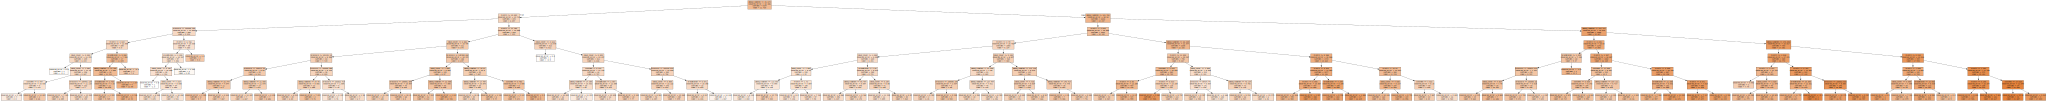

In [50]:
import graphviz
import pylab

tree = sklearn.tree.export_graphviz(clf, out_file=None,
                                    feature_names=x_new_train.columns,
                                filled=True)

# Draw graph
graph = graphviz.Source(tree, format="png")
filename = graph.render(filename='img/tree')
graph

In [51]:
#finally test on validation data
validate_x = weather_validate.drop(columns = ["mean_temp", "index"])
validate_y = weather_validate["mean_temp"]
score = clf.score(validate_x, validate_y)
score

0.7086937651628465